# Energy

In [ ]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = Path(os.getcwd()).parents[0]
sys.path.append(str(path_root))
sys.path.append(str(Path(os.getcwd()).parents[1]))

%reload_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('always', category=FutureWarning)

In [ ]:
from jax import config
config.update("jax_enable_x64", True)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
import jax
import jax.numpy as jnp
from jax import vmap, jit
from tensorflow_probability.substrates.jax import distributions as tfd
import optax
import equinox as eqx
from jax.lib import xla_bridge

In [ ]:
from steinRF.utils import gp_cross_val, metric_model, run_hyperopt, mse, mae, train_test_split
from steinRF.baselines import build_svgp, build_train_svgp, svgp_predict, svgp_cross_val, svgp_nlpd
from steinRF.stein.targets import TFTarget
from steinRF.gp.models import *

In [ ]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


## Data Preparation

In [6]:
key = jax.random.PRNGKey(0)

In [63]:
energy = pd.read_csv("energy.csv")
energy = energy.drop(columns=['cooling_load'])

cont_columns = ['rel_compact', 'surface_area', 'wall_area', 'roof_area', 'overall_height', 'glazing_area']
energy_cont = energy[cont_columns]
X_scaler = MinMaxScaler()
energy[cont_columns] = X_scaler.fit_transform(energy[cont_columns])
y_scaler = StandardScaler()
energy['heating_load'] = y_scaler.fit_transform(np.array(energy['heating_load']).reshape(-1, 1))

X = jnp.array(energy.drop(columns=['heating_load']))
y = jnp.array(energy['heating_load'])
X_train, X_val, y_train, y_val = train_test_split(key, X, y, test_size=0.20)

d = X_train.shape[1]

## Hyperparameter Optimization

In [10]:
# total settings
diag_min, diag_max = 1e-4, 1e-1
epoch_min, epoch_max = 500, 4000
lr_min, lr_max = 1e-3, 4e-1
alpha_min, alpha_max = 0., 3.
q_min, q_max = 2, 10
s_vals = [0, 0.5, 1, 2]


# --------------------------------- Sparse Variational GP -------------------------------- #
def _svgp_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    diag = params.get('diag', None)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", 5e-4, 0.1, log=True)
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = svgp_cross_val(key, X, y, cv_params)
    return cross_val_acc


# ---------------------------------- RFF GP - RBF Kernel --------------------------------- #
def rff_rbf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')
    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = gp_cross_val(build_train_rff_rbf, key, X, y, cv_params)
    return cross_val_acc


# --------------------------------------- RFF BASIC -------------------------------------- #
def rff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')
    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = gp_cross_val(build_train_rff, key, X, y, cv_params)
    return cross_val_acc

# --------------------------------------- STEIN RFF -------------------------------------- #
def srf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')

    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    lr_gd = params.pop('lr_gd', None)
    if lr_gd is None:
        lr_gd = trial.suggest_float("lr_gd", lr_min, lr_max, log=True)
    alpha = params.pop('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max, step=0.2)
    s = params.pop('s', None)
    if s is None:
        s = trial.suggest_categorical("s", s_vals)
    cv_params = {
        'R': R, 'epochs': epochs, 'lr': lr, 'lr_gd': lr_gd, 'diag': diag, 'alpha': alpha, 
        's': s, **params
    }

    # run cross val
    cross_val_acc = gp_cross_val(build_train_srf, key, X, y, cv_params)
    return cross_val_acc


# ------------------------------------ MARGINAL KERNEL ----------------------------------- #
def mix_rff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')

    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    lr_gd = params.pop('lr_gd', None)
    if lr_gd is None:
        lr_gd = trial.suggest_float("lr_gd", lr_min, lr_max, log=True)
    alpha = params.pop('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max, step=0.2)
    q = params.pop('q', None)
    if q is None:
        q = trial.suggest_int("q", q_min, q_max, step=2)
    s = params.pop('s', None)
    if s is None:
        s = trial.suggest_categorical("s", s_vals)

    cv_params = {
        'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, 'lr_gd': lr_gd,
        'alpha': alpha, 's': s, 'q': q, 'kernel': 'rbf', **params
    }

    # run cross val
    n_folds = params.pop('n_folds', 5)
    cross_val_acc = gp_cross_val(build_train_mix_rff, key, X, y, cv_params, n_folds=n_folds)
    return cross_val_acc


### Run Optimization

In [9]:
n_trials = 30
R = 50
hparams = {}

#### Sparse-Variational GP

In [14]:
# svgp = build_train_svgp(key, X, y, R=R, diag=1e-2, epochs=1000, lr=0.01, from_data=True)[0]
svgp_study = run_hyperopt(
    _svgp_cross_val, key, X_train, y_train, n_trials=n_trials, R=R, diag=1e-2, from_data=False
)
hparams["svgp"] = svgp_study.best_params

[I 2024-02-09 15:41:36,118] A new study created in memory with name: no-name-830bbb58-221f-410c-a616-a590204b06fb


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-02-09 15:42:03,500] Trial 0 finished with value: 0.0723546888469429 and parameters: {'epochs': 1500, 'lr': 0.03309772208832381}. Best is trial 0 with value: 0.0723546888469429.
[I 2024-02-09 15:42:45,945] Trial 1 finished with value: 0.07246194621173883 and parameters: {'epochs': 2500, 'lr': 0.04691263826926706}. Best is trial 0 with value: 0.0723546888469429.
[I 2024-02-09 15:43:28,214] Trial 2 finished with value: 0.07228150563602145 and parameters: {'epochs': 2500, 'lr': 0.003437146683193231}. Best is trial 2 with value: 0.07228150563602145.
[I 2024-02-09 15:44:03,141] Trial 3 finished with value: 0.07242275772474403 and parameters: {'epochs': 2000, 'lr': 0.0010333256323531148}. Best is trial 2 with value: 0.07228150563602145.
[I 2024-02-09 15:44:45,362] Trial 4 finished with value: 0.07260437533575247 and parameters: {'epochs': 2500, 'lr': 0.07394452288043542}. Best is trial 2 with value: 0.07228150563602145.
[I 2024-02-09 15:45:20,715] Trial 5 finished with value: 0.072472

#### RFF with RBF

In [15]:
# rff_rbf = build_train_rff_rbf(key, X_train, R=100, diag=1e-2, epochs=1000, lr=0.01, from_data=False)[0]
rff_rbf_study = run_hyperopt(
    rff_rbf_cross_val, key, X_train, y_train, n_trials=n_trials, R=R, epochs=1000, init_ls=False
)
hparams["rff_rbf"] = rff_rbf_study.best_params

[I 2024-02-09 16:03:36,732] A new study created in memory with name: no-name-e9060e73-7972-49a9-8ea5-66e51ca1e1a7


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-02-09 16:03:46,686] Trial 0 finished with value: 0.0030328495574064355 and parameters: {'diag': 0.016627874566784058, 'lr': 0.007184037716470032}. Best is trial 0 with value: 0.0030328495574064355.
[I 2024-02-09 16:03:55,380] Trial 1 finished with value: 0.0030313058714395618 and parameters: {'diag': 0.004040004947784547, 'lr': 0.005323056818645421}. Best is trial 1 with value: 0.0030313058714395618.
[I 2024-02-09 16:04:03,848] Trial 2 finished with value: 0.0028470370548588633 and parameters: {'diag': 0.0002720932043697088, 'lr': 0.008470200724526845}. Best is trial 2 with value: 0.0028470370548588633.
[I 2024-02-09 16:04:12,312] Trial 3 finished with value: 0.0024398497663512095 and parameters: {'diag': 0.002570374171301592, 'lr': 0.0822901381581731}. Best is trial 3 with value: 0.0024398497663512095.
[I 2024-02-09 16:04:20,937] Trial 4 finished with value: 0.004565365144376345 and parameters: {'diag': 0.004412385736989299, 'lr': 0.0028869540397688663}. Best is trial 3 with v

#### Basic RFF GP

In [ ]:
# rff = build_train_rff(key, X_train, y_train, R=R, diag=0.001, epochs=1000, lr=0.05, from_data=False, init_ls=False)[0]
# best 0.0015
rff_study = run_hyperopt(
    rff_cross_val, key, X_train, y_train, n_trials=n_trials, R=R, epochs=1000, from_data=False, init_ls=False
)
hparams["rff"] = rff_study.best_params

#### Stein Random Features

In [16]:
# srf = build_train_srf(key, X_train, y_train, R=R, diag=1e-3, epochs=1000, lr=0.1, alpha=0.5, s=0.5, from_data=False, init_ls=False)[0]
# 0.0020596100864077723
srf_study = run_hyperopt(
    srf_cross_val, key, X_train, y_train, n_trials=50, R=R, epochs=1000, from_data=False, init_ls=False,
    gd_params=lambda t: [t.kernel.transform.scale],
)
hparams["srf"] = srf_study.best_params

[I 2024-02-09 16:11:08,300] A new study created in memory with name: no-name-63da9f47-1ac5-49b5-8dbd-91213a54b2a2


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-02-09 16:11:20,537] Trial 0 finished with value: 0.002407155921893539 and parameters: {'diag': 0.05781837878590701, 'lr': 0.07145935696322236, 'lr_gd': 0.01711045988956662, 'alpha': 2.6, 's': 1}. Best is trial 0 with value: 0.002407155921893539.
[I 2024-02-09 16:11:32,454] Trial 1 finished with value: 0.0021572380871791447 and parameters: {'diag': 0.055722918622498764, 'lr': 0.001972057440411891, 'lr_gd': 0.007529955609092703, 'alpha': 1.8, 's': 0}. Best is trial 1 with value: 0.0021572380871791447.
[I 2024-02-09 16:11:43,640] Trial 2 finished with value: 0.002205458455500357 and parameters: {'diag': 0.002127433079941622, 'lr': 0.027831143065993064, 'lr_gd': 0.35869903418941657, 'alpha': 1.2000000000000002, 's': 0}. Best is trial 1 with value: 0.0021572380871791447.
[I 2024-02-09 16:11:55,212] Trial 3 finished with value: 0.0024868306231082857 and parameters: {'diag': 0.05367691597475788, 'lr': 0.30706270809353986, 'lr_gd': 0.0035344525955690507, 'alpha': 0.4, 's': 0.5}. Best i

#### Mixture SRFR

In [ ]:
prior = TFTarget(tfd.Normal(jnp.zeros(d), jnp.ones(d) * 3))
mix_rff_study = run_hyperopt(
    mix_rff_cross_val, key, X_train, y_train, n_trials=30, R=R, epochs=1000, q=8, diag=1e-4,
    prior=prior, init_ls=False, gd_params=lambda t: [t.kernel.transform.scale], from_data=False, 
)

In [11]:
prior = TFTarget(tfd.Normal(jnp.zeros(d), jnp.ones(d) * 3))
mix_rff_study = run_hyperopt(
    mix_rff_cross_val, key, X_train, y_train, n_trials=75, R=R, epochs=1000, from_data=False, prior=prior, init_ls=False,
    gd_params=lambda t: [t.kernel.transform.scale], 
)

[I 2024-02-09 14:19:37,100] A new study created in memory with name: no-name-1c828705-ce58-4fa3-865e-3707e5c646bb


  0%|          | 0/75 [00:00<?, ?it/s]

[I 2024-02-09 14:20:20,111] Trial 0 finished with value: 0.001548594944027455 and parameters: {'diag': 0.0022742946996100106, 'lr': 0.09073038763378426, 'lr_gd': 0.007460318540195363, 'alpha': 1.4000000000000001, 'q': 2, 's': 1}. Best is trial 0 with value: 0.001548594944027455.
[I 2024-02-09 14:21:03,979] Trial 1 finished with value: 0.0017445334749426257 and parameters: {'diag': 0.004325099909475718, 'lr': 0.24555676874551285, 'lr_gd': 0.0012065065852121704, 'alpha': 3.0, 'q': 2, 's': 1}. Best is trial 0 with value: 0.001548594944027455.
[I 2024-02-09 14:21:48,670] Trial 2 finished with value: 0.002629037505924706 and parameters: {'diag': 0.04277219969537836, 'lr': 0.011137517940353898, 'lr_gd': 0.026589137423570167, 'alpha': 3.0, 'q': 2, 's': 1}. Best is trial 0 with value: 0.001548594944027455.
[I 2024-02-09 14:22:12,569] Trial 3 finished with value: 0.0019560586199172934 and parameters: {'diag': 0.00022592825834054283, 'lr': 0.05313175145696674, 'lr_gd': 0.039612666171528275, 'alp

## Define and Run Experiment

### Definition

In [26]:
def experiment_run(exp_key, X, y, scaler, params, R, restarts=1):    
    # split data
    X_tr, X_test, y_tr, y_test = train_test_split(exp_key, X, y, test_size=0.2)

    ############ SVGP ############
    svgp, _ = build_train_svgp(exp_key, X_tr, y_tr, R=R, **params["svgp"])
    svgp_preds, svgp_sd = svgp_predict(svgp, X_test)
    svgp_metrics = metric_model(y_test, svgp_preds, svgp_sd, scaler=scaler)
    svgp_metrics = jnp.concatenate([svgp_metrics, jnp.atleast_1d(svgp_nlpd(svgp, X_test, y_test))])

    ############ RFF RBF ############
    rff_rbf_gp, _ = build_train_rff_rbf(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["rff_rbf"])
    rff_rbf_preds, rff_rbf_sd = rff_rbf_gp.condition(y_tr, X_test)
    rff_rbf_metrics = metric_model(y_test, rff_rbf_preds, rff_rbf_sd, scaler=scaler)
    rff_rbf_metrics = jnp.concatenate([
        rff_rbf_metrics, jnp.atleast_1d(rff_rbf_gp.nlpd(y_tr, X_test, y_test))
    ])

    ############ RFF ############
    rff_gp, _ = build_train_rff(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["rff"])
    rff_preds, rff_sd = rff_gp.condition(y_tr, X_test)
    rff_metrics = metric_model(y_test, rff_preds, rff_sd, scaler=scaler)
    rff_metrics = jnp.concatenate([
        rff_metrics, jnp.atleast_1d(rff_gp.nlpd(y_tr, X_test, y_test))
    ])

    ############ RFF-Q ############
    # RFF with the equilvalent number of R as the computational complexity of the mixture.
    q = params["mix_rff"]["q"]
    R_equiv_q = int((q * R**3)**(1/3))
    qrff_gp, _ = build_train_rff(exp_key, X_tr, y_tr, R=R_equiv_q, restarts=restarts, **params["rff"])
    qrff_preds, qrff_sd = qrff_gp.condition(y_tr, X_test)
    qrff_metrics = metric_model(y_test, qrff_preds, qrff_sd, scaler=scaler)
    qrff_metrics = jnp.concatenate([
        qrff_metrics, jnp.atleast_1d(qrff_gp.nlpd(y_tr, X_test, y_test))
    ])

    ############ SRF ############
    srf_gp, _ = build_train_srf(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["srf"])
    srf_preds, srf_sd = srf_gp.condition(y_tr, X_test)
    srf_metrics = metric_model(y_test, srf_preds, srf_sd, scaler=scaler)
    srf_metrics = jnp.concatenate([
        srf_metrics, jnp.atleast_1d(srf_gp.nlpd(y_tr, X_test, y_test))
    ])    

    ############ MIX ############
    mix_gp, _ = build_train_mix_rff(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["mix_rff"])
    mix_preds, mix_sd = mix_gp.condition(y_tr, X_test)
    mix_metrics = metric_model(y_test, mix_preds, mix_sd, scaler=scaler)
    mix_metrics = jnp.concatenate([
        mix_metrics, jnp.atleast_1d(mix_gp.nlpd(y_tr, X_test, y_test))
    ])

    metrics = {
        "seed": exp_key[1],
        "svgp": svgp_metrics,
        "rff_rbf": rff_rbf_metrics,
        "rff": rff_metrics,
        "qrff": qrff_metrics,
        "srf": srf_metrics,
        "mix": mix_metrics,
    }

    return metrics

In [27]:
def multi_run(multi_key, X, y, scaler, params, R, n_runs=10):
    metrics = []
    run_keys = jax.random.split(multi_key, n_runs)

    for i in range(n_runs):
        print(f"Running experiment {i+1} of {n_runs}")
        run_res = experiment_run(run_keys[i], X, y, scaler, params, R)
        metrics.append(run_res)
        print(run_res)
    
    return metrics

### Run

In [30]:
# parameters
KEY, subkey = jax.random.split(jax.random.PRNGKey(2024))
params = {
    "svgp": {'epochs': 4000, 'lr': 0.006205596625783714, 'from_data': False, 'diag': 1e-2},
    "rff_rbf": {'init_ls': False, 'epochs': 1000, 'diag': 0.002107794213114641, 'lr': 0.04026430906645888},
    "rff": {'epochs': 1000, 'from_data': False, 'init_ls': False, 'diag': 0.001013232749942153, 'lr': 0.0500335389855656},
    "srf": {
        'diag': 0.0007947091099805349, 'lr': 0.2474468148865163, 'lr_gd': 0.012950616252475348, 'alpha': 2.2, 's': 2,
        'epochs': 1000, 'from_data': False, 'init_ls': False, 'gd_params': lambda t: [t.kernel.transform.scale]
    },
    "mix_rff": {
        'diag': 0.00010349222553994497, 'lr': 0.38778288841293496, 'lr_gd': 0.2860060539057772, 'alpha': 1.4, 'q': 8, 's': 1,
        'epochs': 1000, 'from_data': False, 'init_ls': False, 'gd_params': lambda t: [t.kernel.transform.scale],
        'prior': TFTarget(tfd.Normal(jnp.zeros(d), jnp.ones(d) * 3)),
    },
}

In [31]:
# experiment_run(subkey, X_val, y_val, y_scaler, params, R)
res = multi_run(KEY, X, y, y_scaler, params, R=50, n_runs=10)

Running experiment 1 of 10
{'seed': Array(3007921430, dtype=uint32), 'svgp': Array([8.84916855, 1.98704193, 0.84415585, 0.01973068], dtype=float64), 'rff_rbf': Array([ 2.39230255e-01,  3.44767298e-01,  9.15584385e-01, -7.49805007e-04],      dtype=float64), 'rff': Array([ 1.01681336e-01,  2.27172320e-01,  9.48051929e-01, -4.35881333e-04],      dtype=float64), 'qrff': Array([ 1.18637745e-01,  2.46231495e-01,  9.35064912e-01, -2.21081222e-04],      dtype=float64), 'srf': Array([0.16029243, 0.32310227, 0.87662339, 0.00143389], dtype=float64), 'mix': Array([ 0.07805722,  0.18184272,  0.86363637, -0.00122216], dtype=float64)}
Running experiment 2 of 10
{'seed': Array(2158071644, dtype=uint32), 'svgp': Array([ 7.18543975e+00,  1.84007654e+00,  8.83116901e-01, -3.71704345e-03],      dtype=float64), 'rff_rbf': Array([ 0.26312596,  0.36738678,  0.89610392, -0.00304965], dtype=float64), 'rff': Array([ 1.27193774e-01,  2.57236643e-01,  9.28571403e-01, -1.34932081e-04],      dtype=float64), 'qrff':

In [33]:
res_df = []
for exp in res:
    res_df.extend([[k, *v.tolist()] for k,v in exp.items() if k != "seed"])
res_df = pd.DataFrame(res_df, columns=["model", "mse", "mae", "cal", "z", "nlpd"])
res_df.to_csv("results_cr.csv", index=False)

## Evaluate

In [69]:
res_df = pd.read_csv("results_cr.csv")

names = {
    "rff": "SSGP",
    "rff_rbf": "SSGP-RBF",
    "svgp": "SVGP",
    "srf": "SSGP-SVGD",
    "qrff": "SSGP-$R^*$",
    "mix": "M-SRFR (Ours)",
}

res_df["model"] = res_df["model"].apply(lambda x: names[x])
res_df["rmse"] = np.sqrt(res_df["mse"])
res_df["log_mse"] = np.log(res_df["mse"])

In [71]:
sum_df = res_df.groupby("model").agg(["mean", "std"])
sum_df.columns = sum_df.columns.map(lambda x: '_'.join(x) if isinstance(x, tuple) else x)
sum_df = sum_df.sort_values("rmse_mean", ascending=True).reset_index()
sum_df[['model', 'rmse_mean', 'rmse_std', "nlpd_mean", "nlpd_std"]]

,model,mse_mean,mse_std,mae_mean,mae_std,cal_mean,cal_std,z_mean,z_std,rmse_mean,rmse_std,log_mse_mean,log_mse_std
0,Stein Mixture RFF,0.108771,0.031608,0.224343,0.033271,0.840260,0.033420,-0.000134,0.001535,0.326763,0.047111,-2.255400,0.284330
1,RFF,0.142847,0.034733,0.265743,0.024379,0.918182,0.017370,0.000089,0.001860,0.375700,0.043424,-1.969176,0.220024
2,RFF Equiv Mix Big-O,0.152962,0.027030,0.279638,0.026554,0.912987,0.028420,-0.000231,0.002030,0.389714,0.034720,-1.891880,0.179187
3,RFF-RBF,0.230415,0.033972,0.349459,0.016417,0.933766,0.022031,-0.000330,0.001902,0.478894,0.034556,-1.477112,0.141488
4,Stein RFF,0.299944,0.444622,0.360453,0.231827,0.844805,0.169840,0.000430,0.002048,0.481684,0.274721,-1.636580,0.776567
5,Sparse VGP,7.323303,1.131602,1.850121,0.165098,0.876623,0.035959,-0.004603,0.010917,2.698952,0.208064,1.980391,0.153973


Text(0.5, 1.0, 'Energy UCI Dataset Error')

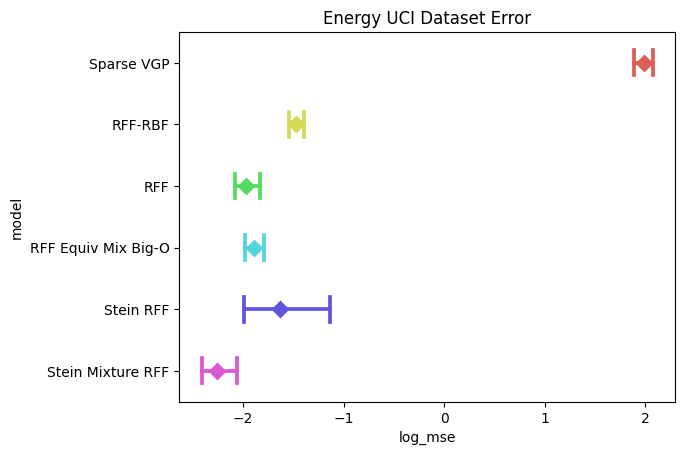

In [36]:
unique_models = res_df["model"].unique()
colors = sns.color_palette("hls", len(unique_models))

pointplot = sns.pointplot(
    data=res_df, x="log_mse", y="model", hue="model",
    errorbar="ci", capsize=.4,
    palette=colors, legend=False,
    color=".5", linestyle="none", marker="D",
)
pointplot.set_title("Airfoil UCI Dataset Error")

## M-SRFR Learned Kernels

In [ ]:
from steinRF.utils import mixture_pred_dists, plot_kernel_mixture, plot_mixture_preds

In [ ]:
rff_gp, single_dist, mix_gp, mixture_dist, y_test = mixture_pred_dists(key, X, y, params, R=50, test_size=0.2)

In [ ]:
kernel_plot = plot_kernel_mixture(
    mix_gp.kernel.kernel.w, plots_per_row=5, bw_adjust=0.85, 
    title="$\\it{energy}$ UCI Dataset: M-SRFR Mixture Kernel Frequencies $\omega$ by Dimension"
)
# kernel_plot.savefig("energy_kernel.pdf", bbox_inches="tight", dpi=300, format="pdf")

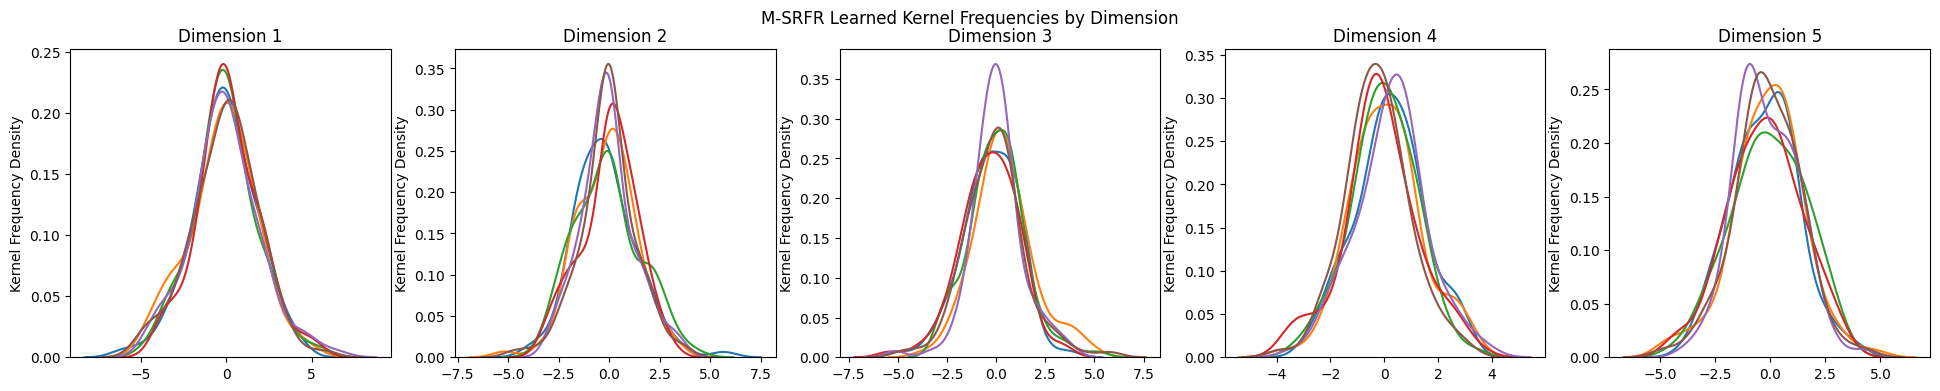

In [ ]:
plot_key = jax.random.PRNGKey(2024)
plot_bounds = jnp.array([y.min(), y.max()])
pred_plot = plot_mixture_preds(
    single_dist, mixture_dist, y_test, n=20, 
    key=plot_key, standardize=False, bounds=plot_bounds,
    title="$\\it{energy}$ UCI Dataset: Sample Predictive Distributions for SSGP and M-SRFR"
)
# pred_plot.savefig("airfoil_preds.pdf", bbox_inches="tight", dpi=300, format="pdf")